<a href="https://colab.research.google.com/github/pentuxxy/Computer-Vision-and-Natural-Language-Processing/blob/main/03_Tim_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Chapter 3 - COMPUTER VISION [Case #2]
Startup Campus, Indonesia - `Artificial Intelligence (AI)` (Batch 7)
* Dataset: MNIST Handwritten Digits (10 classes)
* Libraries: PyTorch, Torchvision, Scikit-learn
* Objective: Transfer Learning using CNN-based Pre-trained Models

`PERSYARATAN` Semua modul (termasuk versi yang sesuai) sudah di-install dengan benar.
<br>`CARA PENGERJAAN` Lengkapi baris kode yang ditandai dengan **#TODO**.
<br>`TARGET PORTFOLIO` Peserta mampu:
* mengimplementasikan teknik *transfer learning* dengan berbagai model *pre-trained* dari PyTorch, dan
* menilai efek pembekuan (*freezing*) beberapa bagian dari layer *neural network*.

<br>`PERINGATAN` **DILARANG MENGUBAH** kode yang ada di dalam *user-defined function (UDFs)*.

### Deskripsi
Sebuah fasilitas robot (*robotics facility*) baru yang berlokasi di Kalimantan Timur, dekat Titik Nol Ibu Kota Negara (IKN) Indonesia, meminta Anda untuk membuat model *Computer Vision* untuk produk robot baru mereka. Perusahaan meminta Anda untuk mengajari robot cara membaca rangkaian angka. Anda tiba-tiba menyadari bahwa tahap pertama adalah membiarkan robot mengidentifikasi setiap digit dengan benar (0-9). Namun, karena tanggal pengumuman prototipe dipercepat, *deadline* Anda sangat ketat: Anda hanya memiliki waktu kurang dari 1 minggu untuk menyelesaikan pekerjaan. Sebagai pengembang AI profesional, Anda tetap tenang dan tahu bahwa Anda dapat memanfaatkan metode **Transfer Learning** untuk menyelesaikan masalah ini secara efisien.

Database **Modified National Institute of Standards and Technology (MNIST)** berisi 10 digit tulisan tangan. Semuanya berada dalam skala grayscale (1 channel). Torchvision, sub-library dari PyTorch, memiliki lusinan model terlatih yang dapat Anda pilih dengan mudah. Semua model ini awalnya dilatih pada kumpulan data ImageNet [(ref1)](https://www.image-net.org/download.php), yang berisi jutaan gambar RGB (3 channel) dan 1.000 kelas. Untuk mempermudah, pilihlah **Resnet18** [(ref2)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), **DenseNet121** [(ref3)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf), and **Vision Transformer (ViT)** [(ref4)](https://arxiv.org/pdf/2010.11929.pdf) sebagai model dasar (namun canggih) untuk menguji performa klasifikasi gambar. Sekarang, tugas lengkap Anda adalah sebagai berikut.

1. Pilih DenseNet sebagai model pertama untuk bereksperimen, lalu **ubah jumlah neuron di lapisan pertama dan terakhir** (karena ImageNet memiliki 1.000 kelas, sedangkan MNIST hanya memiliki 10 kelas; keduanya juga memiliki ukuran gambar dan *channel* yang berbeda).
2. Tentukan **hyperparameter** dan latih modelnya (semua layer dilatih dari awal).
3. Plot performa model, baik untuk hasil **pelatihan** maupun **validasi**.
4. Sekarang, coba **bekukan (freeze, tidak dilatih) beberapa bagian dari layer**: (1) "denseblock1", (2) "denseblock1" dan "denseblock2". Ini akan menjadi dua model terpisah.
5. **Latih kembali** (*retrain*) setiap model, visualisasikan performanya, dan periksa perbedaannya.
6. BONUS: Bisakah Anda **mereplikasi** semua langkah di atas dengan model yang berbeda, misalnya **ResNet** dan **ViT**?

### Import libraries

In [ ]:
import torch, torchvision, time
from numpy.random import seed
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-5061f0ddd5d4>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
torch.__version__ == "2.0.1+cu117"

False

In [ ]:
torchvision.__version__ == "0.15.2+cu117"

False

In [ ]:
# define seeding
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

### User-defined Functions (UDFs)

- To print total model parameters

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

- To get the pair of train and validation dataloaders

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
])

train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform, download=True).train_data.float()

def get_dataloaders(train_batch_size : int, val_batch_size : int, max_rows : int = 1000, *args, **kwargs) -> tuple:
    data_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform)
    train_idx = torch.randperm(len(train_dataset))[:int(max_rows*.75)]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, \
                                               sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=data_transform)
    val_idx = torch.randperm(len(val_dataset))[:int(max_rows*.25)]
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, \
                                             sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    return train_loader, val_loader

* To fit (training) the model

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

* To visualize the model performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Define the model class

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection: str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 1  # untuk gambar grayscale

        def create_conv2d(this_layer, *args, **kwargs) -> torch.nn.Conv2d:
            return torch.nn.Conv2d(
                in_channels=self.in_channels, out_channels=this_layer.out_channels,
                kernel_size=this_layer.kernel_size, stride=this_layer.stride,
                padding=this_layer.padding, bias=True if this_layer.bias is not None else False
            )

        # Memeriksa pemilihan model yang valid
        if not self.model_selection.lower() in ["resnet", "densenet", "vit"]:
            raise ValueError("Silakan pilih model: 'resnet', 'densenet', atau 'vit'.")

        if self.model_selection == "resnet":
            # Load ResNet yang telah dilatih sebelumnya dan modifikasi layer input/output
            self.model = torchvision.models.resnet18(pretrained=True)
            self.model.conv1 = create_conv2d(self.model.conv1)  # Ubah layer input menjadi grayscale
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10)  # Output 10 kelas

        elif self.model_selection == "densenet":
            # Load DenseNet yang telah dilatih sebelumnya dan modifikasi layer input/output
            self.model = torchvision.models.densenet121(pretrained=True)
            self.model.features.conv0 = create_conv2d(self.model.features.conv0)  # Ubah layer input menjadi grayscale
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 10)  # Output 10 kelas

        elif self.model_selection == "vit":
            # Load Vision Transformer yang telah dilatih sebelumnya dan modifikasi layer input/output
            self.model = torchvision.models.vit_b_16(pretrained=True)
            # Sesuaikan layer proyeksi input untuk grayscale
            self.model.conv_proj = torch.nn.Conv2d(1, self.model.conv_proj.out_channels, kernel_size=16, stride=16, bias=False)
            self.model.heads = torch.nn.Linear(self.model.heads.head.in_features, 10)  # Output 10 kelas

        # Layer Softmax untuk klasifikasi multi-kelas
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torch.Tensor:
        x = self.model(data)
        return self.softmax(x)


### Set device to CUDA
**PERHATIAN**: Di Google Colab, klik Runtime > Change Runtime Type, lalu pilih **T4 GPU**.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define hyperparameters

In [ ]:
EPOCH = 5
BATCH_SIZE = 16  # (DONE) TODO: Tentukan nilai batch size (32 or 64 or 128 batch size)
LEARNING_RATE = 1e-5 # (DONE) TODO: Tentukan nilai learning rate (bisa gunakan 1e-4 or 1e-3)

### Define the model

In [ ]:
# (DONE) TODO: Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
model = VisionModel("densenet").to(device) #saya gunakan pertama kali ("resnet")
check_params(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 83.2MB/s]


{'total_trainable_params': 6957834, 'total_nontrainable_params': 0}

In [ ]:
model

VisionModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

### WILL BE USED LATER: Freeze some layers

In [ ]:
model_freeze_block1 = deepcopy(model)
for name, param in model_freeze_block1.named_parameters():
    if param.requires_grad and "denseblock1" in name:
        param.requires_grad = False
check_params(model_freeze_block1)

{'total_trainable_params': 6622794, 'total_nontrainable_params': 335040}

In [ ]:
model_freeze_block12 = deepcopy(model)
for name, param in model_freeze_block12.named_parameters():
    if param.requires_grad and any([x in name for x in ["denseblock1", "denseblock2"]]):
        param.requires_grad = False
check_params(model_freeze_block12)

{'total_trainable_params': 5703114, 'total_nontrainable_params': 1254720}

### Get train and validation dataloaders

To speedup the training time, we will only use 1,000 (of 60,000) images from MNIST.

In [ ]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, BATCH_SIZE)
len(train_loader), len(val_loader)

(47, 16)

### Set loss function and model optimizer

In [ ]:
loss_function = torch.nn.CrossEntropyLoss() # (DONE) Tentukan loss function (untuk multi-classification)

trainable_model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

### Start the model training

In [ ]:
# (DONE) TODO: Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
results = fit(
    model = model,
    epoch = EPOCH,
    train_loader = train_loader,
    val_loader = val_loader
)

Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.255, Validation loss: 2.265, Validation accuracy: 17.656


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.150, Validation loss: 2.112, Validation accuracy: 58.672


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.049, Validation loss: 2.012, Validation accuracy: 76.953


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.942, Validation loss: 1.904, Validation accuracy: 83.594


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.831, Validation loss: 1.809, Validation accuracy: 87.109
Training time: 50.457s


In [ ]:
results

{'model': 'densenet',
 'train_acc': [0.25132978723404253,
  0.47074468085106386,
  0.7125759872984379,
  0.8288373858370679,
  0.8822188453471407],
 'train_loss': [2.2554455564377154,
  2.1502031113239046,
  2.0490336265969784,
  1.9420889616012573,
  1.8311927191754604],
 'val_acc': [0.17656250018626451,
  0.5867187492549419,
  0.76953125,
  0.8359375,
  0.87109375],
 'val_loss': [2.264588385820389,
  2.112189397215843,
  2.0118785947561264,
  1.9038621559739113,
  1.809495985507965],
 'exc_time': 50.456966400146484}

### Plot the model performance

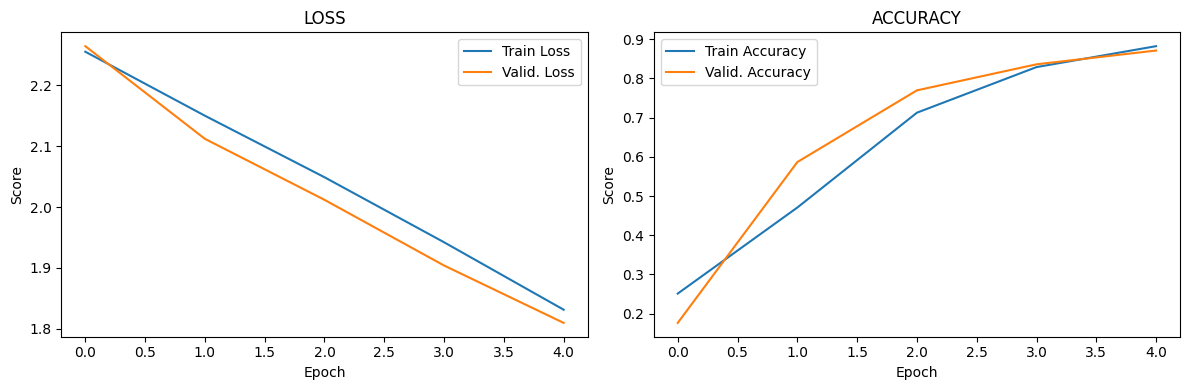

In [ ]:
plot_performance(results)

### NEXT ROUND: Retrain the model with frozen layers

In [ ]:
FROZEN_RESULTS = []
for idx, m in enumerate([model_freeze_block1, model_freeze_block12]):
    print("id: {}".format(idx))
    trainable_model_params = [p for p in m.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    new_results = fit(model=m, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)
    FROZEN_RESULTS.append(new_results)

id: 0


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.263, Validation loss: 2.271, Validation accuracy: 15.469


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.150, Validation loss: 2.120, Validation accuracy: 61.484


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.050, Validation loss: 2.029, Validation accuracy: 77.266


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.957, Validation loss: 1.922, Validation accuracy: 81.797


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.854, Validation loss: 1.843, Validation accuracy: 82.109
Training time: 42.120s
id: 1


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.266, Validation loss: 2.268, Validation accuracy: 19.609


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.169, Validation loss: 2.139, Validation accuracy: 54.141


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.080, Validation loss: 2.054, Validation accuracy: 71.406


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.989, Validation loss: 1.958, Validation accuracy: 82.734


Loss:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.895, Validation loss: 1.868, Validation accuracy: 84.141
Training time: 41.293s


### Examine the difference in both accuracy and loss

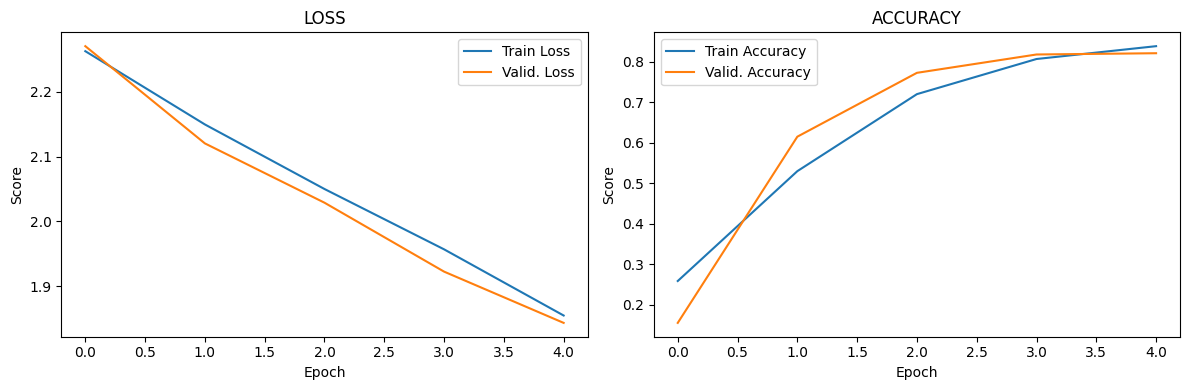

In [ ]:
plot_performance(FROZEN_RESULTS[0])

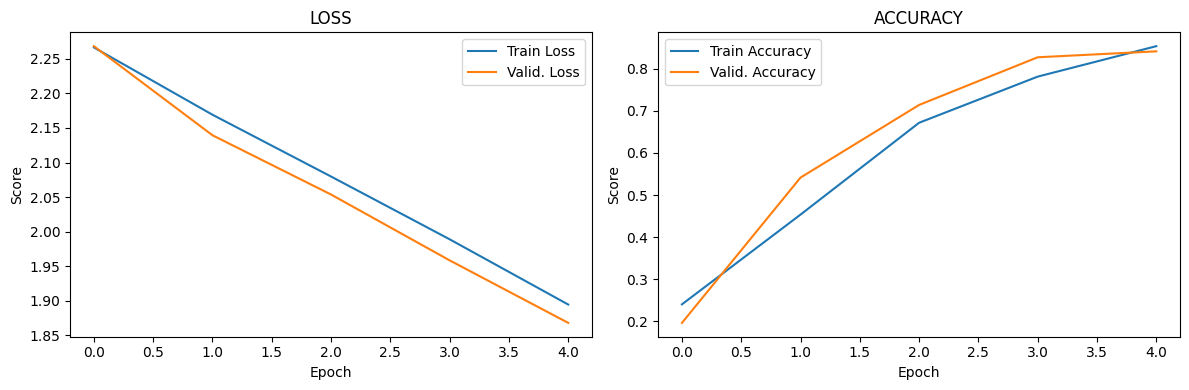

In [ ]:
plot_performance(FROZEN_RESULTS[1])

In [ ]:
# [ PERTANYAAN ]
# TODO: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?

[ ANSWER HERE ] <br>
Ada beberapa faktor yang menyebabkan Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhiri, antara lain:
1.   Ketidakcocokan Domain: Model yang dilatih di domain berbeda mungkin tidak
mengekstrak fitur relevan untuk tugas baru.
2.   Batasan Ekstraksi Fitur: Fitur yang dibekukan mungkin tidak sesuai untuk masalah spesifik, menghambat pembelajaran.
3.   Pelatihan Tidak Memadai: Lima epoch mungkin tidak cukup untuk menyempurnakan lapisan, menghambat penyesuaian bobot.
4.   Overfitting: Model dengan kapasitas tinggi dan data terbatas bisa terlalu cocok dengan set pelatihan.
5.  Sensitivitas Kecepatan Pembelajaran: Kecepatan pembelajaran yang tidak tepat dapat menyebabkan ketidakstabilan atau pelatihan tidak memadai

In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?

[ ANSWER HERE ]<br>
ada beberapa alasan semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch), antara lain:
1.   Kemampuan Beradaptasi Terbatas: Membekukan lapisan menghambat model untuk menyesuaikan ekstraksi fitur dengan kumpulan data baru, terutama jika domainnya berbeda, sehingga performa awal rendah.
2.   Masalah Inisialisasi: Lapisan yang tidak dibekukan mulai dari bobot yang mungkin tidak sesuai, mengakibatkan kerugian dan akurasi rendah di awal pelatihan.
3.   Dinamika Pembelajaran: Dengan lebih sedikit lapisan yang dapat dilatih, lapisan yang tersisa harus mengekstrak fitur tanpa modifikasi representasi yang lebih dalam, menyulitkan proses belajar.
4.   Ketidakcocokan Representasi Fitur: Fitur dari lapisan beku mungkin tidak relevan untuk tugas baru, seperti klasifikasi digit MNIST.
5.   Masalah Aliran Gradien: Membekukan banyak lapisan dapat mengganggu aliran gradien, menyulitkan pembelajaran.
6.   Risiko Overfitting: Banyak lapisan yang dibekukan meningkatkan risiko model terlalu cocok dengan data pelatihan.

### Examine the difference in the execution time

In [ ]:
print("When all layers were TRAINABLE: {:.3f}s.".format(results["exc_time"]))
print("Only 'denseblock1' was FROZEN: {:.3f}s.".format(FROZEN_RESULTS[0]["exc_time"]))
print("Only 'denseblock1' and 'denseblock2' wwere FROZEN: {:.3f}s.".format(FROZEN_RESULTS[1]["exc_time"]))

When all layers were TRAINABLE: 50.457s.
Only 'denseblock1' was FROZEN: 42.120s.
Only 'denseblock1' and 'denseblock2' wwere FROZEN: 41.293s.


In [ ]:
# [ PERTANYAAN ]
# TODO: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

[ ANSWER HERE ]<br>
Semakin banyak layer yang di-freeze dalam transfer learning, semakin cepat waktu training dan validasi karena:


1.   Pengurangan Perhitungan Gradien: Layer yang di-freeze tidak memerlukan perhitungan gradien, mengurangi beban komputasi pada backpropagation.
2.   Pengurangan Update Bobot: Layer yang di-freeze tidak mengalami update parameter, mempercepat proses optimisasi.
3.   Forward Pass Lebih Sederhana: Layer yang di-freeze hanya memproses input tanpa memperhitungkan perubahan bobot, sehingga lebih efisien.
4.   Penggunaan Memori Rendah: Layer yang di-freeze tidak menyimpan gradien atau cache aktivasi, mengurangi beban memori GPU.
5.   Validasi Lebih Cepat: Validasi hanya melalui forward pass, tanpa perhitungan gradien atau update bobot.

### Scoring
Total `#TODO` = 12
<br>Checklist:

- [✔️] Ubah susunan input layer DenseNet dengan memanggil create_conv2d()
- [✔️] Ubah output layer DenseNet dengan 10 kelas
- [✔️] Ubah susunan input layer ViT dengan memanggil create_conv2d()
- [✔️] Ubah output layer ViT dengan 10 kelas
- [✔️] Tentukan nilai batch size
- [✔️] Tentukan nilai learning rate
- [✔️] Tentukan loss function (untuk multi-classification)
- [✔️] Isi parameter dengan "resnet" untuk ResNet18, atau "densenet" untuk DenseNet121, dan "vit" untuk Vision Transformer.
- [✔️] Panggil model, lalu tentukan besaran epoch, train data loader, dan validation data loader
- [✔️] PERTANYAAN: Dengan 5 iterasi yang sama pada training, mengapa Transfer Learning dengan layer yang di-freeze lebih buruk di akurasi akhir?
- [✔️] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin rendah akurasi model di awal iterasi (epoch)?
- [✔️] PERTANYAAN: Mengapa semakin banyak layer yang di-freeze, semakin cepat waktu training dan validasinya?

### Additional readings
* ResNet: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* DenseNet: https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
* Vision Transformer (ViT): https://arxiv.org/pdf/2010.11929.pdf
* MNIST Classification w/ PyTorch (Beginner): https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc

### Copyright © 2024 Startup Campus, Indonesia
* Prepared by **Nicholas Dominic, M.Kom.** [(profile)](https://linkedin.com/in/nicholas-dominic)
* You may **NOT** use this file except there is written permission from PT. Kampus Merdeka Belajar (Startup Campus).
* Please address your questions to mentors.